## Ticker $BUD Stock Price Prediction Using RNNs

## Daily Version

In [37]:
#import libraries for data wrangling
import pandas as pd
import numpy as np
import pynance as pn
from ta import add_all_ta_features
from ta.utils import dropna
from pandas.tseries.frequencies import to_offset
from datetime import timedelta
import pandas_ta as ta

In [64]:
#set start dates for training; roughly 15 years worth of data range
start = '01/01/2010'
end = '06/08/2022'

In [65]:
#creatre df from stock data for $BUD using date ranges
bud = pd.DataFrame(pn.data.get('bud', start,end)).sort_values(by = 'Date', ascending = True).reset_index()

In [66]:
#worth noting, I am not a finance prof. The IVs calculated are common indicators traders use
#calculate model independent variables
bud['RSI50'] = ta.rsi(bud['Close'], timeperiod = 50)#calcs relative strength index
bud['EMA50'] = ta.ema(bud['Close'], timeperiod = 50)#calcs exponential moving average
bud['SMA50'] = ta.sma(bud['Close'], timeperiod = 50)#calcs simple moving average
bud['Delta'] = bud['Open'] - bud['Close']

In [67]:
dbud = bud.dropna().sort_values(by = 'Date', ascending = False);dbud #drops any records that contain null values
#only null values should be the first 50 records, this is due to the selection of IVs being calc i=50

,Date,Open,High,Low,Close,Volume,RSI50,EMA50,SMA50,Delta
3128,2022-06-08,55.920,55.940,55.010,55.180,812620,45.202758,55.749985,55.9540,0.740
3127,2022-06-07,55.850,56.420,55.445,56.320,1083133,50.576790,55.876648,55.9600,-0.470
3126,2022-06-06,56.000,56.530,55.545,55.850,936520,48.220087,55.778126,55.8810,0.150
3125,2022-06-03,55.900,56.070,55.430,55.530,1237362,46.610565,55.762154,55.7230,0.370
3124,2022-06-02,54.960,55.740,54.340,55.660,1036346,47.163598,55.813743,55.5760,-0.700
...,...,...,...,...,...,...,...,...,...,...
18,2010-01-29,38.570,38.778,37.687,38.015,433572,36.373257,37.794742,37.5089,0.555
17,2010-01-28,38.441,38.472,37.220,37.463,275169,30.949108,37.745796,37.6683,0.978
16,2010-01-27,37.854,38.015,37.623,37.968,367962,33.365439,37.808640,37.8761,-0.114
15,2010-01-26,36.327,37.143,36.221,36.732,208941,18.991283,37.773226,37.9883,-0.405


In [68]:
#import libraries for modeling
import scipy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [69]:
#set random seed for reproducibility
tf.random.set_seed(1234)

In [70]:
#split data into train set
train_size = int(len(dbud)*0.7) #creating training set to 70% of total data
train_dataset, test_dataset = dbud[0:train_size], dbud.iloc[train_size:len(dbud)]

#split data into test set
train_size = int(len(dbud)*0.3) #creating training set to 30% of total data
train_dataset, test_dataset = dbud.iloc[train_size:], dbud.iloc[:train_size]

Dimension of train data:  (2181, 10)
Dimension of test data:  (934, 10)


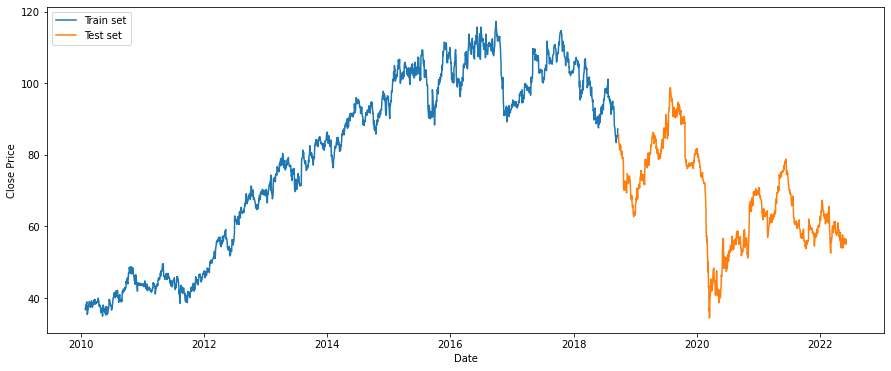

In [71]:
# Plot train and test data
plt.figure(figsize = (15, 6))
plt.plot(train_dataset.Date,train_dataset.Close)
plt.plot(test_dataset.Date,test_dataset.Close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [72]:
# Split train data to X and y
X_train = train_dataset.drop(['Date','Close','Open'], axis = 1)
y_train = train_dataset.loc[:,['Close']]

# Split test data to X and y
X_test = test_dataset.drop(['Date','Close','Open'], axis = 1)
y_test = test_dataset.loc[:,['Close']]

In [73]:
# Different scaler for input and output; normalize data
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [74]:
# Create a 3D input; this is similar to creating a sliding window from dates. 
#This is taking 60 days of time to study patterns
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 60

X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)

print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (874, 60, 7)
y_train.shape:  (2121, 1)
X_test.shape:  (874, 60, 7)
y_test.shape:  (2121, 1)


In [75]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# BiLSTM
model_bilstm = create_model_bilstm(64)

# GRU
model_gru = create_model(64, GRU)

#LSTM
model_lstm = create_model(64, LSTM)

In [76]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])
    return history
history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/100
53/53 [==============================] - 3s 64ms/step - loss: 0.0308 - val_loss: 6.6528e-04
Epoch 2/100
53/53 [==============================] - 2s 42ms/step - loss: 0.0090 - val_loss: 3.1471e-04
Epoch 3/100
53/53 [==============================] - 2s 41ms/step - loss: 0.0015 - val_loss: 3.6120e-04
Epoch 4/100
53/53 [==============================] - 2s 40ms/step - loss: 0.0016 - val_loss: 1.5817e-04
Epoch 5/100
53/53 [==============================] - 2s 40ms/step - loss: 0.0011 - val_loss: 2.0894e-04
Epoch 6/100
53/53 [==============================] - 2s 40ms/step - loss: 8.3013e-04 - val_loss: 1.7674e-04
Epoch 7/100
53/53 [==============================] - 2s 40ms/step - loss: 5.6089e-04 - val_loss: 1.4782e-04
Epoch 8/100
53/53 [==============================] - 2s 40ms/step - loss: 6.4191e-04 - val_loss: 1.5320e-04
Epoch 9/100
53/53 [==============================] - 2s 40ms/step - loss: 5.3461e-04 - val_loss: 1.9344e-04
Epoch 10/100
53/53 [============================

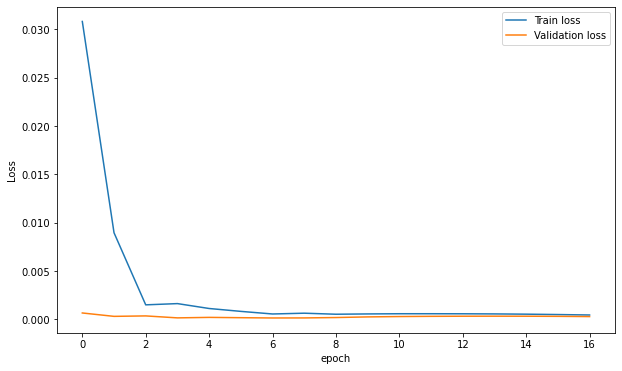

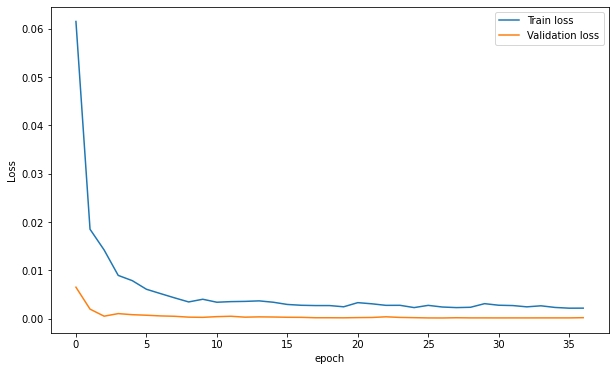

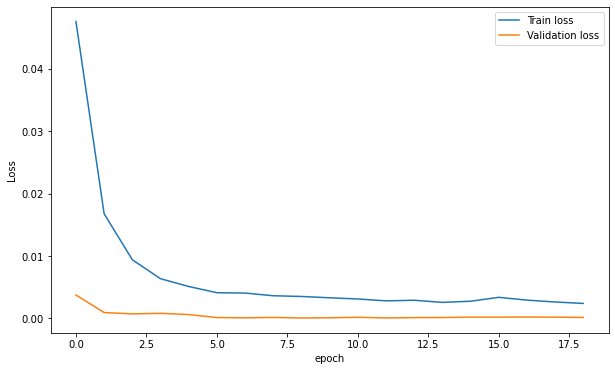

In [77]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss (history_bilstm)
plot_loss (history_lstm)
plot_loss (history_gru)

In [78]:
#inverse the normalization back to raw values
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

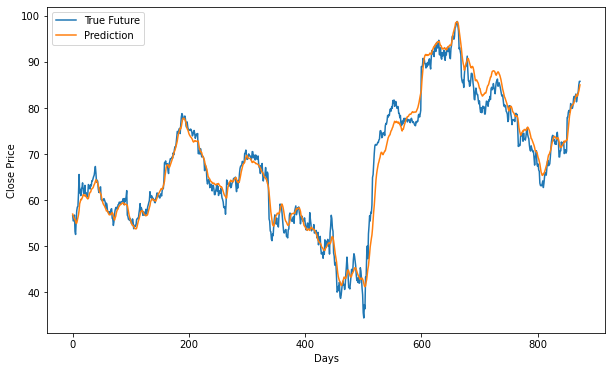

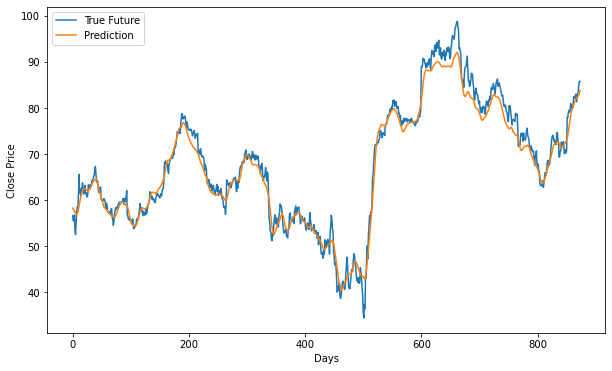

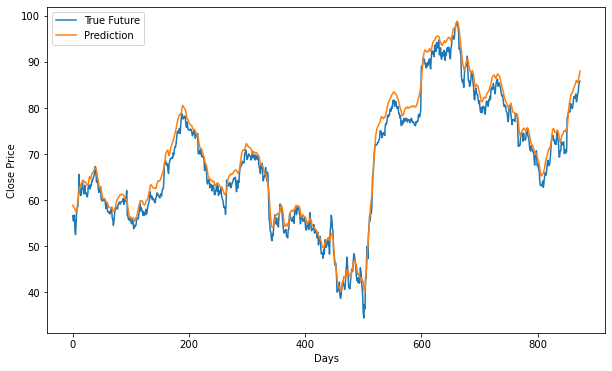

In [79]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Days')
    plt.ylabel('Close Price')

plot_future(prediction_bilstm, y_test)
plot_future(prediction_lstm, y_test)
plot_future(prediction_gru, y_test)

In [80]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 1.7998
Root Mean Square Error: 2.4390

LSTM:
Mean Absolute Error: 1.7092
Root Mean Square Error: 2.2291

GRU:
Mean Absolute Error: 1.8896
Root Mean Square Error: 2.2042



## Weekly Version

In [81]:
#bins into weeks, don't run unless want weeklies
logic = {'Open'  : 'first',
         'High'  : 'max',
         'Low'   : 'min',
         'Close' : 'last',
         'Volume': 'sum'}
df = bud.set_index('Date')

offset = to_offset(pd.DateOffset(days=-6))

df_resample = df.resample('1W', loffset=offset).apply(logic)

<ipython-input-81-0032c7679bcf>:11: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  df_resample = df.resample('1W', loffset=offset).apply(logic)


In [82]:
#worth noting, I am not a finance prof. The IVs calculated are common indicators traders use
#calculate model independent variables
df_resample['RSI10'] = ta.rsi(df_resample['Close'], timeperiod = 10)#calcs relative strength index
df_resample['EMA10'] = ta.ema(df_resample['Close'], timeperiod = 10)#calcs exponential moving average
df_resample['SMA10'] = ta.sma(df_resample['Close'], timeperiod = 10)#calcs simple moving average
df_resample['Delta'] = df_resample['Open'] - df_resample['Close']

In [83]:
df_resample = df_resample.dropna().sort_values(by = 'Date', ascending = False);df_resample.reset_index() #drops any records that contain null values
#only null values should be the first 10 records, this is due to the selection of IVs being calc i=50days

,Date,Open,High,Low,Close,Volume,RSI10,EMA10,SMA10,Delta
0,2022-06-06,56.000,56.530,55.010,55.180,2832273,42.977119,56.519111,56.5270,0.820
1,2022-05-30,56.370,56.770,54.340,55.530,5653601,43.594709,56.816691,57.0868,0.840
2,2022-05-23,54.780,56.860,54.620,56.650,4431916,45.539236,57.102622,57.4419,-1.870
3,2022-05-16,55.710,57.640,53.430,54.270,5354665,40.283298,57.203205,57.7942,1.440
4,2022-05-09,53.710,56.055,53.500,56.010,9506922,43.107577,57.855028,57.9179,-2.300
...,...,...,...,...,...,...,...,...,...,...
630,2010-05-10,37.119,38.508,35.914,36.425,4214620,43.638211,37.289247,37.8734,0.694
631,2010-05-03,36.647,37.409,32.973,34.968,6668483,37.653228,37.481302,38.0178,1.679
632,2010-04-26,37.570,37.662,35.563,36.989,3368684,43.619148,38.039814,38.3346,0.581
633,2010-04-19,37.586,38.288,37.002,37.522,3714552,45.379971,38.273328,38.4777,0.064


In [84]:
#import libraries for modeling
import scipy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [85]:
#set random seed for reproducibility
tf.random.set_seed(1234)

In [86]:
#split data into train set
train_size = int(len(df_resample)*0.7) #creating training set to 70% of total data
train_dataset, test_dataset = df_resample[0:train_size], df_resample.iloc[train_size:len(df_resample)]

#split data into test set
train_size = int(len(df_resample)*0.3) #creating training set to 30% of total data
train_dataset, test_dataset = df_resample.iloc[train_size:].reset_index(), df_resample.iloc[:train_size].reset_index()

Dimension of train data:  (445, 10)
Dimension of test data:  (190, 10)


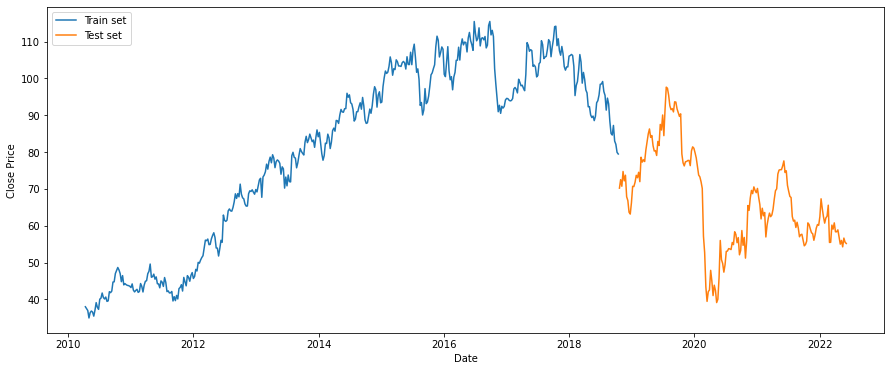

In [87]:
# Plot train and test data
plt.figure(figsize = (15, 6))
plt.plot(train_dataset.Date,train_dataset.Close)
plt.plot(test_dataset.Date,test_dataset.Close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [88]:
# Split train data to X and y
X_train = train_dataset.drop(['Date','Close','Open'], axis = 1)
y_train = train_dataset.loc[:,['Close']]

# Split test data to X and y
X_test = test_dataset.drop(['Date','Close','Open'], axis = 1)
y_test = test_dataset.loc[:,['Close']]

In [89]:
# Different scaler for input and output; normalize data
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [90]:
# Create a 3D input; this is similar to creating a sliding window from dates. 
#This is taking 60 days of time to study patterns
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 12

X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)

print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (178, 12, 7)
y_train.shape:  (433, 1)
X_test.shape:  (178, 12, 7)
y_test.shape:  (433, 1)


In [91]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# BiLSTM
model_bilstm = create_model_bilstm(64)

# GRU
model_gru = create_model(64, GRU)

#LSTM
model_lstm = create_model(64, LSTM)

In [92]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])
    return history
history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/100
11/11 [==============================] - 1s 115ms/step - loss: 0.1346 - val_loss: 6.3545e-04
Epoch 2/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0238 - val_loss: 0.0013
Epoch 3/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0062 - val_loss: 5.3718e-04
Epoch 4/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0035 - val_loss: 6.8755e-04
Epoch 5/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 5.1920e-04
Epoch 6/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 5.3561e-04
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 5.0611e-04
Epoch 8/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 5.1728e-04
Epoch 9/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 4.6406e-04
Epoch 10/100
11/11 [==============================] - 0s 13ms/step 

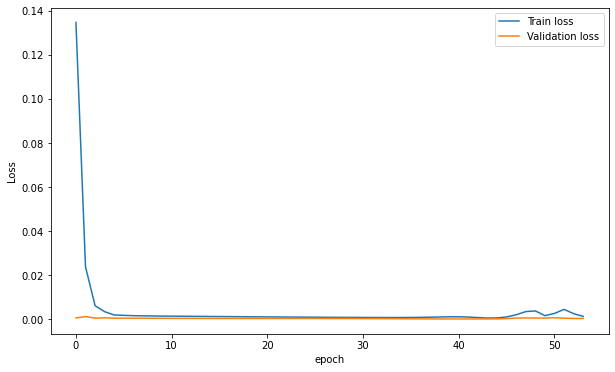

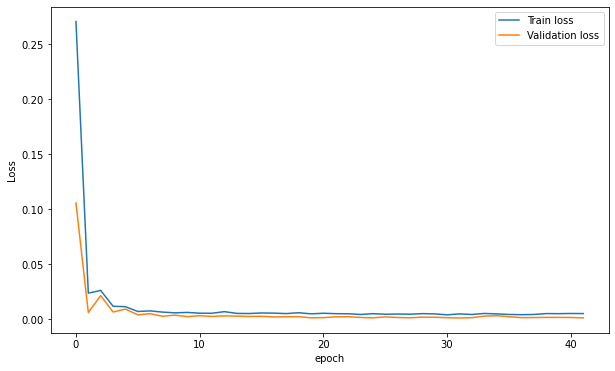

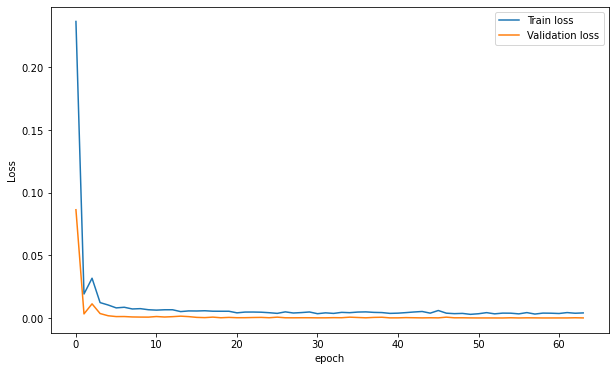

In [93]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss (history_bilstm)
plot_loss (history_lstm)
plot_loss (history_gru)

In [94]:
#inverse the normalization back to raw values
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

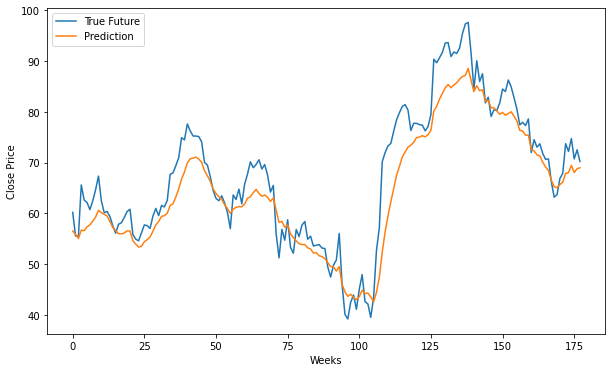

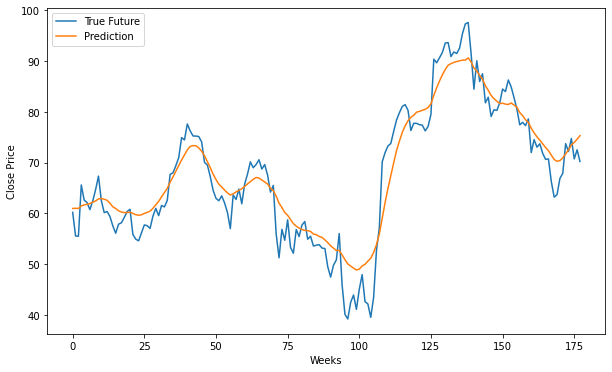

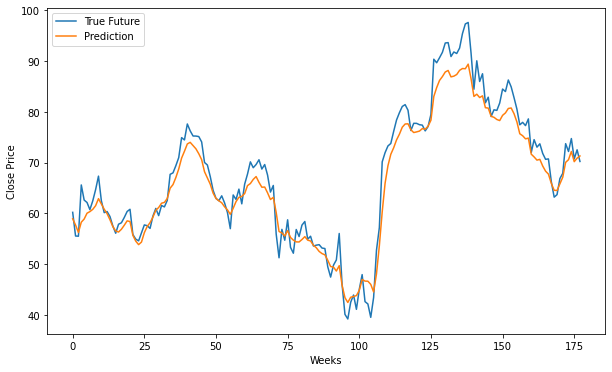

In [95]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Weeks')
    plt.ylabel('Close Price')

plot_future(prediction_bilstm, y_test)
plot_future(prediction_lstm, y_test)
plot_future(prediction_gru, y_test)

In [96]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 3.8002
Root Mean Square Error: 4.9371

LSTM:
Mean Absolute Error: 3.2828
Root Mean Square Error: 4.0796

GRU:
Mean Absolute Error: 2.4570
Root Mean Square Error: 3.1016



In [100]:
##save weekly model
!mkdir -p saved_model
model_bilstm.save(r'C:\Users\doped\bud_rnn\models\BiLSTM_Weekly')
model_lstm.save(r'C:\Users\doped\bud_rnn\models\LSTM_Weekly')
model_gru.save(r'C:\Users\doped\bud_rnn\models\GRU_Weekly')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: C:\Users\doped\bud_rnn\models\BiLSTM_Weekly\assets
INFO:tensorflow:Assets written to: C:\Users\doped\bud_rnn\models\LSTM_Weekly\assets
INFO:tensorflow:Assets written to: C:\Users\doped\bud_rnn\models\GRU_Weekly\assets
